# Download The Data:
https://figshare.com/articles/dataset/Deep_Image_Reconstruction/7033577?file=14830631
https://figshare.com/articles/dataset/Deep_Image_Reconstruction/7033577?file=14830862

In [1]:
!pip install bdpy

In [2]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import bdpy
import tensorflow as tf

In [3]:
import glob

train_files = glob.glob('./train/*.JPEG')

f2i_train = {}
with open('./train.tsv') as f:
    for line in f:
        image_name, index = line.split('\t')
        f2i_train[int(index)-1] = image_name

f2i_test = {}
with open('./test.tsv') as f:
    for line in f:
        image_name, index = line.split('\t')
        f2i_test[int(index)-1] = image_name

In [4]:
print(len(f2i_train))
print(len(f2i_test))

1200
50


In [5]:
from bdpy import BData

fmri_train_data = [sample for sample in np.load('./train_256.npy')]
fmri_test_data = [sample for sample in np.load('./test_256.npy')]

print(np.array(fmri_train_data).shape)
print(np.array(fmri_test_data).shape)

(6000, 256)
(1200, 256)


In [6]:
from PIL import Image
import numpy as np
import os


train_images = []
bad_train_indices = []
for f in range(len(fmri_train_data)):
    ff = f%1200
    image_name = f2i_train[ff]
    if not os.path.exists(f'./64x64/{image_name}.JPEG'):
        bad_train_indices.append(f)
        img = np.random.normal(size=(64,64,3))
    else:
        img = np.asarray(Image.open(f'./64x64/{image_name}.JPEG'))
        if img.shape == (64,64,3):
            pass
        elif img.shape == (64, 64):
            img = np.tile(img.reshape((64,64,1)), (1,1,3))
        else:
            bad_train_indices.append(f)
            img = np.random.normal(size=(64,64,3))
    train_images.append(img)

test_images = []
bad_test_indices = []
for f in range(len(fmri_test_data)):
    ff = f%50
    image_name = f2i_test[ff]
    if not (os.path.exists(f'./64x64/{image_name}.JPEG')):
        bad_test_indices.append(f)
        img = np.random.normal(size=(64,64,3))
    else:
        img = np.asarray(Image.open(f'./64x64/{image_name}.JPEG'))
        if img.shape == (64,64,3):
            pass
        elif img.shape == (64,64):
            img = np.tile(img.reshape((64,64,1)), (1,1,3))
        else:
            bad_test_indices.append(f)
            img = np.random.normal(size=(64,64,3))
    test_images.append(img)

print(bad_train_indices)
print(bad_test_indices)

print(np.array(train_images).shape)
print(np.array(test_images).shape)

[0, 1, 2, 3, 4, 6, 7, 1200, 1201, 1202, 1203, 1204, 1206, 1207, 2400, 2401, 2402, 2403, 2404, 2406, 2407, 3600, 3601, 3602, 3603, 3604, 3606, 3607, 4800, 4801, 4802, 4803, 4804, 4806, 4807]
[]
(6000, 64, 64, 3)
(1200, 64, 64, 3)


In [7]:
bad_train_indices = set(bad_train_indices)
bad_test_indices = set(bad_test_indices)

new_train_images = []
new_train_fmri = []
for i in range(len(train_images)):
    if i not in bad_train_indices:
        new_train_images.append(train_images[i])
        new_train_fmri.append(fmri_train_data[i])

new_test_images = []
new_test_fmri = []
for i in range(len(test_images)):
    if i not in bad_test_indices:
        new_test_images.append(test_images[i])
        new_test_fmri.append(fmri_test_data[i])

train_images = np.array(new_train_images)
train_fmri = np.array(new_train_fmri)

test_images = np.array(new_test_images)
test_fmri = np.array(new_test_fmri)

print(train_images.shape)
print(train_fmri.shape)

print(test_images.shape)
print(test_fmri.shape)

(5965, 64, 64, 3)
(5965, 256)
(1200, 64, 64, 3)
(1200, 256)


In [8]:
all_data = np.concatenate([train_images, test_images], axis=0)
dmin, dmax = min(np.min(all_data), np.min(all_data)), max(np.max(all_data), np.max(all_data))
dscale = max(abs(dmin), abs(dmax))
print("dmin: ", dmin, "dmax: ", dmax)
print("dscale: ", dscale)

x0 = train_images / dscale 
x1 = test_images / dscale
print()

all_cond = np.concatenate([train_fmri, test_fmri], axis=0)
cmin, cmax = min(np.min(all_cond), np.min(all_cond)), max(np.max(all_cond), np.max(all_cond))
cscale = max(abs(cmin), abs(cmax))
print("cmin: ", cmin, "cmax: ", cmax)
print("cscale: ", cscale)

c0 = (train_fmri / cscale + 1) / 2
c1 = (test_fmri / cscale + 1) / 2
print()

print('x0.shape: ', x0.shape)
print("x0min: ", np.min(x0), "x0max: ", np.max(x0))
print('c0.shape: ', c0.shape)
print("c0min: ", np.min(c0), "c0max: ", np.max(c0))

dmin:  0 dmax:  255
dscale:  255

cmin:  -24.293573 cmax:  21.175053
cscale:  24.293573

x0.shape:  (5965, 64, 64, 3)
x0min:  0.0 x0max:  1.0
c0.shape:  (5965, 256)
c0min:  0.0 c0max:  0.9251978


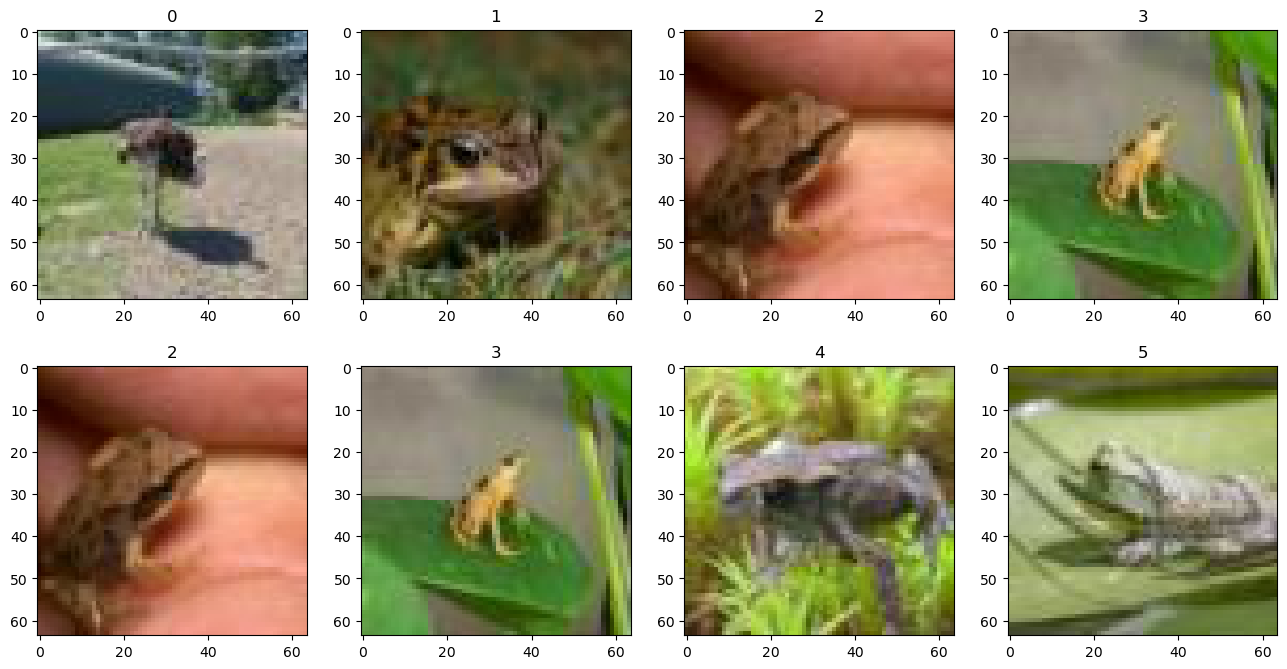

In [10]:
rows = 2
fig, ax = plt.subplots(nrows=rows, ncols=4)
for r in range(rows):
    for c in range(4):
        sample_img = x0[2*r + c]
        ax[r][c].imshow(sample_img, cmap="gray")
        ax[r][c].set_title(f'{2*r+c}')

fig.set_size_inches(16, 4*rows)

plt.show()

In [11]:
%load_ext autoreload
%autoreload 2

In [21]:
from tensorflow.keras.layers import *
latent_dim = 256

encoder = tf.keras.Sequential([
    Input((64, 64, 3)),
    Conv2D(128, 2, 2, activation="relu"),
    Conv2D(128, 2, 2, activation="relu"),
    Conv2D(256, 2, 2, activation="relu"),
    Conv2D(256, 2, 2, activation="relu"),
    Conv2D(512, 2, 2, activation="relu"),
    Conv2D(512, 2, 2, activation="relu"),
    Flatten(),
    Dense(2*latent_dim),
], name = "encoder")

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 32, 32, 128)       1664      
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 128)       65664     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 8, 8, 256)         131328    
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 4, 4, 256)         262400    
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 2, 2, 512)         524800    
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 1, 1, 512)         1049088   
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0   

In [66]:
decoder = tf.keras.Sequential([
    Input((2*latent_dim)),
    Dense((7*7*64)),
    Reshape((7,7,64)),
    Conv2DTranspose(64, 3, 2, activation="relu"),
    Conv2DTranspose(64, 3, 2, activation="relu"),
    Conv2DTranspose(64, 2, 2, activation="relu"),
    Conv2DTranspose(64, 2, 1, activation="relu"),
    Conv2DTranspose(3, 2, 1, activation="relu"),
], name = "decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 3136)              1608768   
_________________________________________________________________
reshape_26 (Reshape)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_122 (Conv2D (None, 15, 15, 64)        36928     
_________________________________________________________________
conv2d_transpose_123 (Conv2D (None, 31, 31, 64)        36928     
_________________________________________________________________
conv2d_transpose_124 (Conv2D (None, 62, 62, 64)        16448     
_________________________________________________________________
conv2d_transpose_125 (Conv2D (None, 63, 63, 64)        16448     
_________________________________________________________________
conv2d_transpose_126 (Conv2D (None, 64, 64, 3)         771 

In [67]:
from cond_autoencoder import VAE

kl_beta = tf.Variable(0.0, trainable=False)
vae = VAE(encoder, decoder, kl_beta=kl_beta)

vae((x0, c0))


vae.summary()

Model: "vae_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 512)               2297600   
_________________________________________________________________
decoder (Sequential)         (None, 64, 64, 3)         1716291   
Total params: 4,013,900
Trainable params: 4,013,891
Non-trainable params: 9
_________________________________________________________________


In [68]:
vae.compile(
      optimizer=tf.keras.optimizers.Adam(0.0005)
)

# Train

In [72]:
from cond_autoencoder import KL_Callback

kl_callback = KL_Callback(kl_beta, 0.0005, 0.0005, 20)

loss = vae.fit(
    x=[x0, c0], 
    epochs=100, 
    batch_size=32,
    callbacks=[kl_callback]
)

Epoch 1/100
kl_beta: 0.00050
187/187 [==============================] - 23s 122ms/step - loss: 0.0091 - reconstruction_loss: 0.0081 - kl_loss: 2.1865 - kl_beta: 5.0000e-04
Epoch 2/100
kl_beta: 0.00050
187/187 [==============================] - 22s 119ms/step - loss: 0.0088 - reconstruction_loss: 0.0077 - kl_loss: 2.1928 - kl_beta: 5.0000e-04
Epoch 3/100
kl_beta: 0.00050
187/187 [==============================] - 21s 113ms/step - loss: 0.0087 - reconstruction_loss: 0.0076 - kl_loss: 2.1983 - kl_beta: 5.0000e-04
Epoch 4/100
kl_beta: 0.00050
187/187 [==============================] - 21s 113ms/step - loss: 0.0084 - reconstruction_loss: 0.0073 - kl_loss: 2.2019 - kl_beta: 5.0000e-04
Epoch 5/100
kl_beta: 0.00050
187/187 [==============================] - 21s 114ms/step - loss: 0.0082 - reconstruction_loss: 0.0071 - kl_loss: 2.2083 - kl_beta: 5.0000e-04
Epoch 6/100
kl_beta: 0.00050
187/187 [==============================] - 21s 114ms/step - loss: 0.0081 - reconstruction_loss: 0.0070 - kl_los

KeyboardInterrupt: 

In [73]:
import json
with open('./_100e_1e-3.json', 'w') as f:
    json.dump(loss.history, f)


NameError: name 'loss' is not defined

# Plot Reconstruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


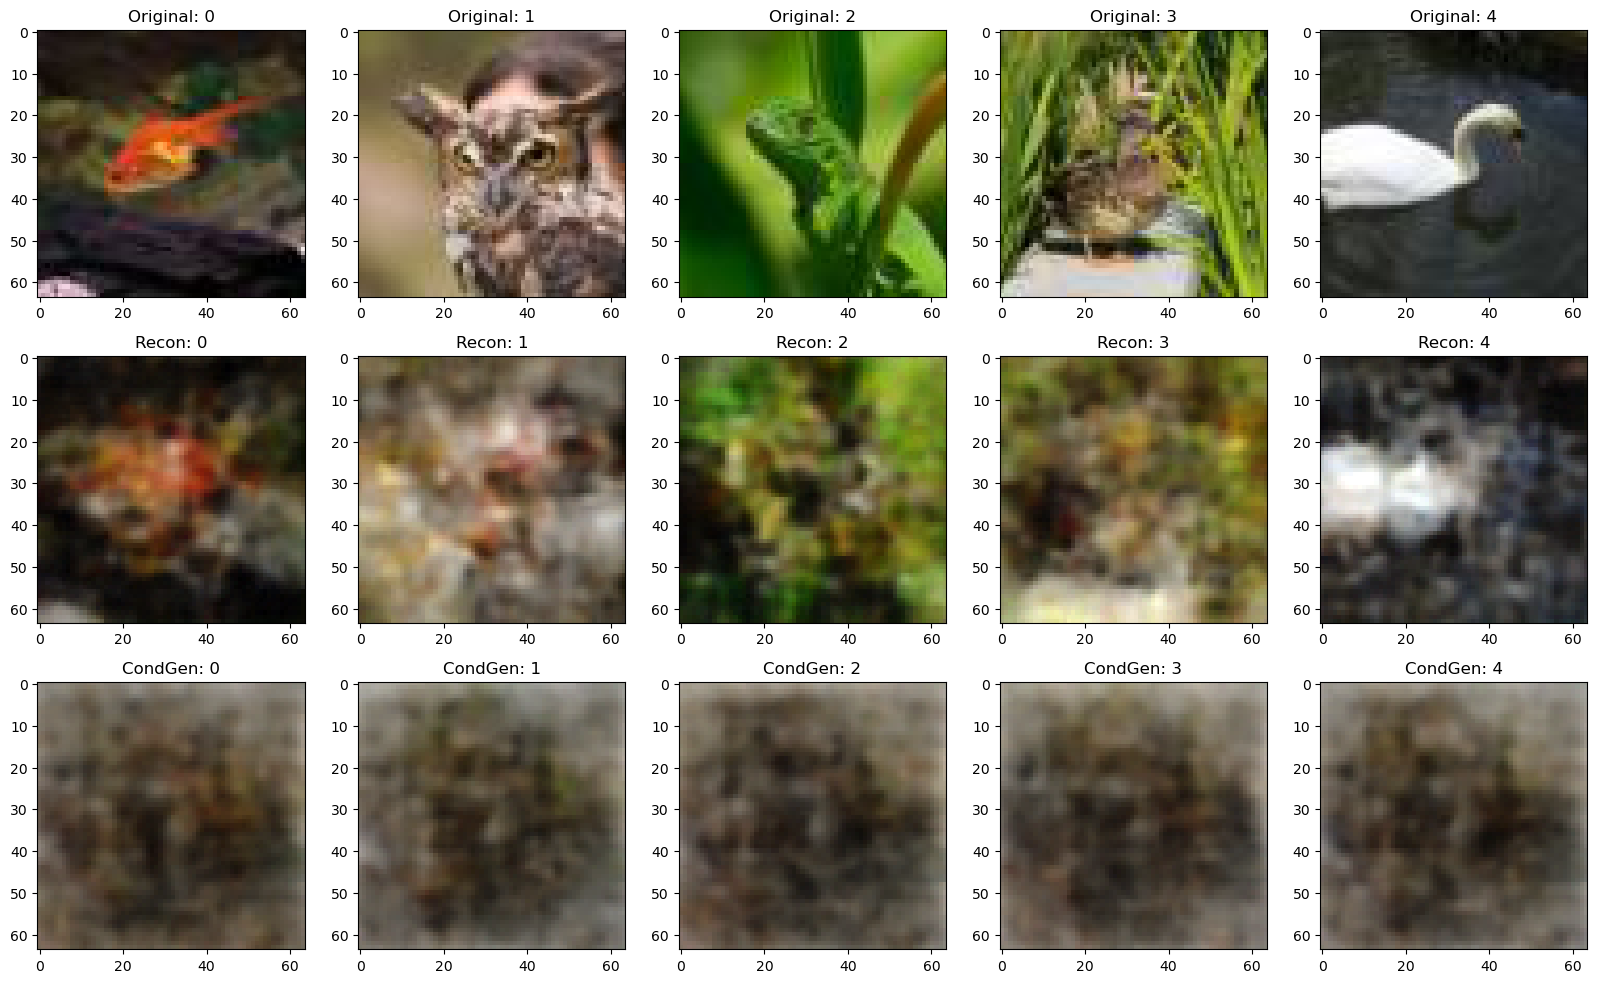

In [74]:
n = 5

test_sample = x1[:n]
test_cond = c1[:n]

recon = vae((test_sample, test_cond))

noise = np.random.uniform(0, 1, size=(n, latent_dim))
gen = vae.decoder(tf.concat((noise, test_cond), axis=-1))

fig, ax = plt.subplots(nrows=3, ncols=n)

fig.set_size_inches((4*n, 12))
for i in range(n):
  ax[0][i].imshow(test_sample[i])
  ax[0][i].set_title(f'Original: {i}')
  ax[1][i].imshow(recon[i])
  ax[1][i].set_title(f'Recon: {i}')
  ax[2][i].imshow(gen[i])
  ax[2][i].set_title(f'CondGen: {i}')

# Save Model

In [84]:
import time
t = int(time.time())

vae.save(f'./Trained Models/VAE/trained_vae_model_{t}')

# Get Embeddings

In [5]:
training_embeddings = model.encoder(train_data)
testing_embeddings = model.encoder(test_data)
print(training_embeddings.shape)
print(testing_embeddings.shape)

(6000, 512)
(1200, 512)


# Load Model

In [4]:
model = tf.keras.models.load_model('./Trained Models/VAE/trained_vae_model_1670286874')

In [27]:
import json

fn_idx = []
test_fn_idx = []
with open('../metadata/stimulus_perceptionNaturalImageTraining.tsv') as f:
    fn_idx = f.read().splitlines()
    fn_idx = [l.split('\t')[0] for l in fn_idx]

with open('../metadata/stimulus_perceptionNaturalImageTest.tsv') as f:
    test_fn_idx = f.read().splitlines()
    test_fn_idx = [l.split('\t')[0] for l in test_fn_idx]

print(len(fn_idx))
print(len(test_fn_idx))

with open('./directory.json', 'w') as f:
    directory = {}
    for s, sample in enumerate(training_embeddings):
        filename = fn_idx[s%1200]
        embedding = sample.numpy().tolist()

        if filename in directory:
            directory[filename].append(embedding)
        else:
            directory[filename] = [embedding]
    
    for s, sample in enumerate(testing_embeddings):
        filename = test_fn_idx[s%50]
        embedding = sample.numpy().tolist()

        if filename in directory:
            directory[filename].append(embedding)
        else:
            directory[filename] = [embedding]

    print(len(directory))
    print(len(directory[list(directory.keys())[0]]))
            
    json.dump(directory, f)

1200
50
1250
5


In [25]:
with open('../../imagenet/fmri_images/directory.json','r') as f:
    j = json.load(f)

    print(list(j.keys())[:10])

['n01518878_10042', 'n01518878_12028', 'n01518878_14075', 'n01518878_14910', 'n01518878_5958', 'n01518878_7346', 'n01518878_7579', 'n01518878_8432', 'n01639765_22407', 'n01639765_32862']


In [17]:
import glob

all_images = list(glob.iglob('../../imagenet/fmri_images/**/*.JPEG' , recursive=True))

print(f'allimages: {len(all_images)}')

print(len(directory))

allimages: 1243
1200
